In [1]:

import os
import sys
import numpy as np
import tensorflow as tf
import motornet as mn

print('All packages imported.')
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)


All packages imported.
tensorflow version: 2.13.0
numpy version: 1.24.3


In [2]:
import matplotlib.pyplot as plt

def plot_simulations(xy, target_xy, filename = None):
  plotor = mn.utils.plotor.plot_pos_over_time
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(15,5))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1.1, 1.1])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  if filename is not None: 
    plt.savefig(filename)

In [11]:
from motornet.plants.muscles import RigidTendonHillMuscle
import matplotlib.pyplot as plt
from models import bilateral_wtAdd_CC_lesioned, MotorNetModelDual
from tasks import RandomTargetReach
import copy


# just use this to get lossweights to edit

plant = mn.plants.RigidTendonArm26(mn.plants.muscles.RigidTendonHillMuscle())
network = bilateral_wtAdd_CC_lesioned(plant=plant, n_units=5, n_hidden_layers=2, name='network')
task = RandomTargetReach(network=network, deriv_weight = 0.05)

loss_weights1 = copy.deepcopy(task.loss_weights)
loss_weights2 = copy.deepcopy(task.loss_weights)

loss_weights1['excitation'] = 0.
for i in network.layer_state_names:
    loss_weights1[i] = 0.02
loss_weights2['excitation'] = 2.
for i in network.layer_state_names:
    loss_weights2[i] = 0.


loss_weights1['cartesian position'] = 5.
loss_weights1['cartesian position2'] = 0.
loss_weights2['cartesian position'] = 0.
loss_weights2['cartesian position2'] = 5.

In [12]:
loss_weights1

{'joint position': 0.0,
 'cartesian position': 5.0,
 'cartesian position2': 0.0,
 'muscle state': 0.0,
 'geometry state': 0.0,
 'proprioceptive feedback': 0.0,
 'visual feedback': 0.0,
 'excitation': 0.0,
 'hidden_l_0': 0.02,
 'hidden_r_0': 0.02,
 'hidden_l_1': 0.02,
 'hidden_r_1': 0.02}

Epoch 1/10
100/100 [==============================] - 35s 146ms/step - val_loss: 435.2170 - val_position_loss: 0.2714 - val_position2_loss: 1.1295 - val_muscle_activation_loss: 0.2286 - val_gru_regularizer_loss: 0.1440
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - val_loss: 311.9673 - val_position_loss: 0.2737 - val_position2_loss: 1.1688 - val_muscle_activation_loss: 0.1607 - val_gru_regularizer_loss: 0.1399
Epoch 3/10
100/100 [==============================] - 12s 125ms/step - val_loss: 201.8132 - val_position_loss: 0.2714 - val_position2_loss: 1.1433 - val_muscle_activation_loss: 0.1005 - val_gru_regularizer_loss: 0.1269
Epoch 4/10
100/100 [==============================] - 13s 126ms/step - val_loss: 105.5615 - val_position_loss: 0.2679 - val_position2_loss: 1.1260 - val_muscle_activation_loss: 0.0490 - val_gru_regularizer_loss: 0.1130
Epoch 5/10
100/100 [==============================] - 12s 124ms/step - val_loss: 40.6923 - val_position_loss: 0.2687 - val_p

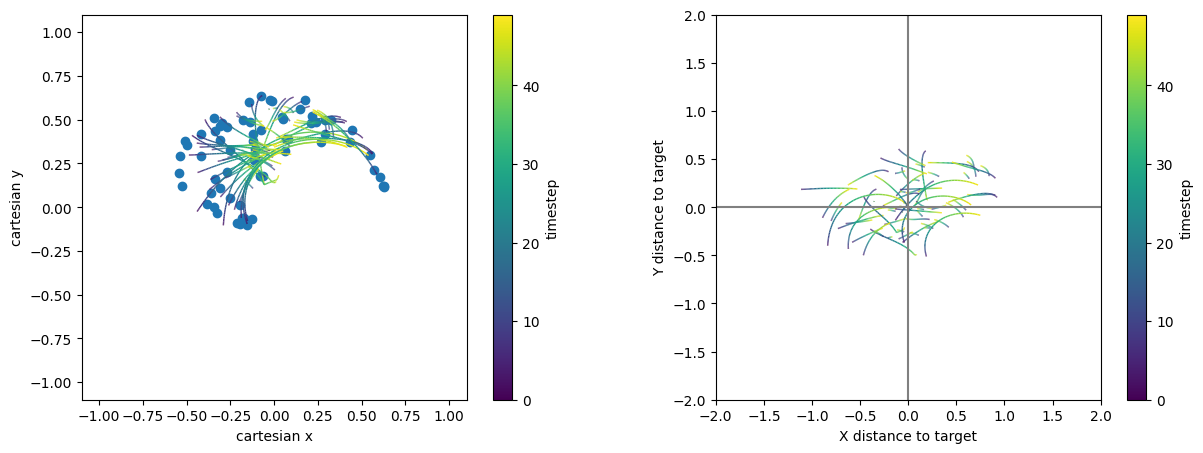

In [13]:
# Training of a specialised model

n_t = 50
n_batches = 100
batch_size = 64

u=10
l=2
lr=0.001

#Choose Skeleton and Muscle type (Plant)
plant = mn.plants.RigidTendonArm26(RigidTendonHillMuscle())

# Choose network architecture (CC in this case)
network = bilateral_wtAdd_CC_lesioned(plant=plant, n_units=int(u/2), n_hidden_layers=l, name='network', lesion = None)

# Choose task (Random Reach)
task = RandomTargetReach(network=network, deriv_weight = 0.05)
rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

tf.random.set_seed(1)
np.random.seed(1)

input_dict = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(input_dict, state0)

# Trains a specialised model. dual_loss_weights are the 2 different loss functions for specialisation
model = MotorNetModelDual(inputs=[input_dict, state0], outputs=states_out, name='model', task=task, dual_loss_weights = [loss_weights1, loss_weights2])
model.compile(optimizer=tf.optimizers.Adam(clipnorm=1., learning_rate = lr), loss=task.losses, loss_weights=task.loss_weights)

#tensorboard callbacks
log_dir = "logs/fit/example/u"+str(u)+"l"+str(l)+"lr"+str(lr)+"s"+str(1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stop = tf.keras.callbacks.EarlyStopping(
          monitor="val_loss",
          patience=3,
          start_from_epoch=0,
)

callbacks = [mn.nets.callbacks.BatchLogger(),tensorboard_callback,early_stop]

#generate task instances
[inputs, targets, init_states] = model.task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
[inputs_v, targets_v, init_states_v] = model.task.generate(n_timesteps=n_t, batch_size=batch_size)

#fit model
h = model.fit(x=[inputs, init_states], y=targets,validation_data=([inputs_v, init_states_v], targets_v), verbose=1, epochs=10, batch_size=batch_size, shuffle=True, callbacks=callbacks)

#weights can be saved like this
model.save_weights(filepath="logs/fit/example/weight_bin/u"+str(u)+"l"+str(l)+"lr"+str(lr)+"s"+str(1))

results = model([inputs_v, init_states_v], training=False)
plot_simulations(xy=results["cartesian position"], target_xy=targets_v)

#model performance bad because of low training epochs. Early epochs tend to reduce muscle activation for quick wins


Epoch 1/10
[<tf.Tensor 'gradient_tape/model/RNN/while/Identity_18:0' shape=(16, 5) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_19:0' shape=(5,) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_20:0' shape=(16, 5) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_21:0' shape=(5,) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_22:0' shape=(5, 5) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_23:0' shape=(5,) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_24:0' shape=(5, 5) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_25:0' shape=(5,) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_26:0' shape=() dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_27:0' shape=() dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_28:0' shape=(5, 6) dtype=float32>, <tf.Tensor 'gradient_tape/model/RNN/while/Identity_29:0'

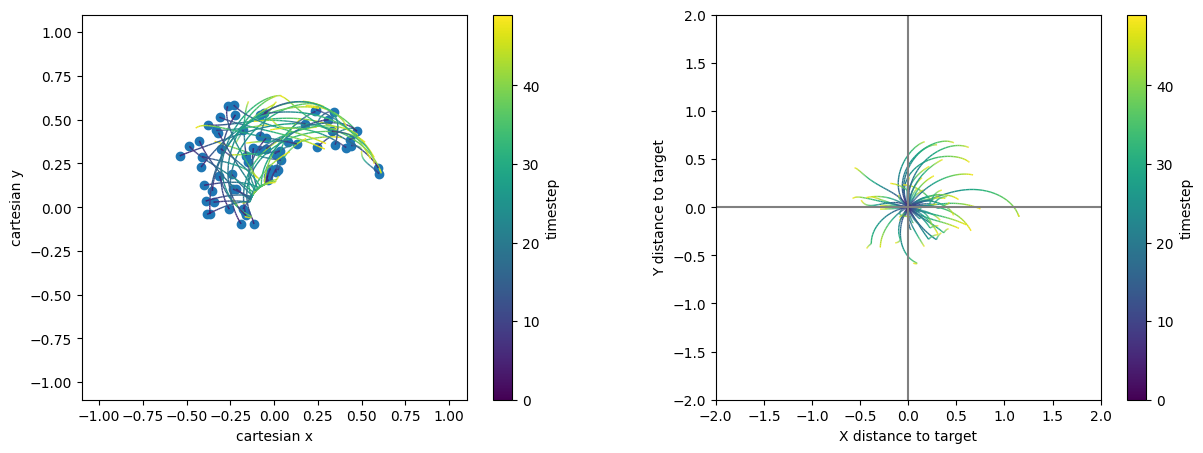

In [7]:
from tasks import HoldPositionWithLoads
from models import bilateral_wtAdd_lesioned

# Training of a non-specialised model

n_t = 50
n_batches = 100
batch_size = 64

u=10
l=2
lr=0.001

#Choose Skeleton and Muscle type (Plant)
plant = mn.plants.RigidTendonArm26(RigidTendonHillMuscle())

# Choose network architecture (Bi in this case)
network = bilateral_wtAdd_lesioned(plant=plant, n_units=int(u/2), n_hidden_layers=l, name='network', lesion = None)

# Choose task (Hold Position)
task = HoldPositionWithLoads(network=network, deriv_weight = 0.05, endpoint_load_bounds=[-10,10])
rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

tf.random.set_seed(1)
np.random.seed(1)

input_dict = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(input_dict, state0)

# Trains a non-specialised model.
model = mn.nets.MotorNetModel(inputs=[input_dict, state0], outputs=states_out, name='model', task=task)
model.compile(optimizer=tf.optimizers.Adam(clipnorm=1., learning_rate = lr), loss=task.losses, loss_weights=task.loss_weights)

#tensorboard callbacks
log_dir = "logs/fit/example_hold/u"+str(u)+"l"+str(l)+"lr"+str(lr)+"s"+str(1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stop = tf.keras.callbacks.EarlyStopping(
          monitor="val_loss",
          patience=3,
          start_from_epoch=0,
)

callbacks = [mn.nets.callbacks.BatchLogger(),tensorboard_callback,early_stop]

#generate task instances
[inputs, targets, init_states] = model.task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
[inputs_v, targets_v, init_states_v] = model.task.generate(n_timesteps=n_t, batch_size=batch_size)

#fit model
h = model.fit(x=[inputs, init_states], y=targets,validation_data=([inputs_v, init_states_v], targets_v), verbose=1, epochs=10, batch_size=batch_size, shuffle=True, callbacks=callbacks)

#weights can be saved like this
model.save_weights(filepath="logs/fit/example_hold/weight_bin/u"+str(u)+"l"+str(l)+"lr"+str(lr)+"s"+str(1))

results = model([inputs_v, init_states_v], training=False)
plot_simulations(xy=results["cartesian position"], target_xy=targets_v)

#model performance bad because of low training epochs. Early epochs tend to reduce muscle activation for quick wins